In [732]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

In [733]:
print(f"PyTorch Version: {torch.__version__}")

PyTorch Version: 2.4.1+cpu


In [734]:
def add_noise(y_base, low=0, high=0.2):
  # Random signs (-1 or 1)
  signs = torch.where(torch.rand(y_base.shape) > 0.5, 1.0, -1.0)

  # Random scale within bounds
  scales = torch.rand(y_base.shape) * (high - low) + low

  return signs * scales * y_base

SSR: 123.9533


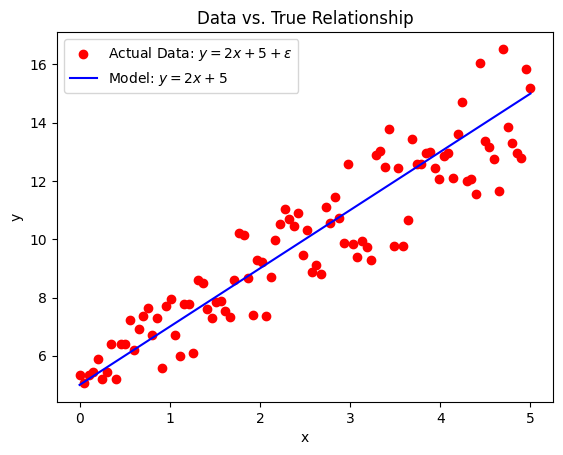

In [735]:
_ = torch.manual_seed(5)
x = torch.linspace(0, 5, 100)

# Underlying true relationship: y = 2x + 5
true_beta1 = 2
true_beta0 = 5

# Add Noise (ε)
y_base = true_beta1 * x + true_beta0
noise = add_noise(y_base)
y = y_base + noise

# Model Prediction (using known parameters)
y_pred = true_beta1 * x + true_beta0
ssr = torch.sum((y - y_pred) ** 2)
print(f"SSR: {ssr:.4f}")

# Plotting
_ = plt.scatter(x, y, color='red', label=r'Actual Data: $y = 2x + 5 + \epsilon$')
_ = plt.plot(x, y_pred, label=f'Model: $y = {true_beta1}x + {true_beta0}$', color='blue')
_ = plt.title('Data vs. True Relationship')
_ = plt.xlabel('x')
_ = plt.ylabel('y')
_ = plt.legend()

### Analytical Best Fit

We use `numpy.polyfit()` to find the optimal coefficients analytically via Ordinary Least Squares (OLS). This gives us the "ground truth" best fit line, which we will later aim to reach using iterative Gradient Descent.

SSR: 114.5550
Learned Equation: y = 1.81x + 5.35


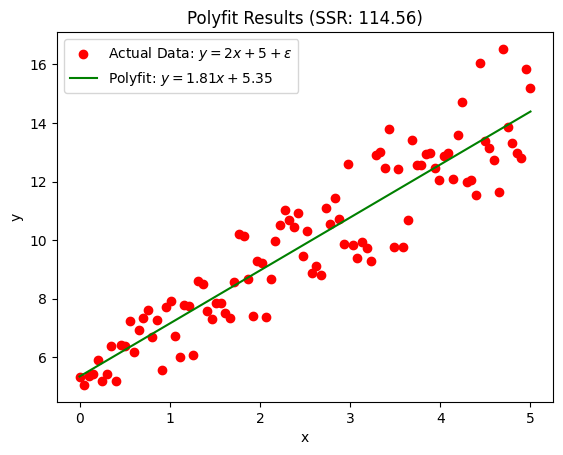

In [736]:
# Model Training (OLS using polyfit)
# deg=1 for linear regression (y = mx + b)
m, b = np.polyfit(x, y, deg=1)

# Prediction & Metrics
y_pred = m * x + b
ssr = torch.sum((y - y_pred) ** 2)
print(f"SSR: {ssr:.4f}")
print(f"Learned Equation: y = {m:.2f}x + {b:.2f}")

# Plotting
_ = plt.scatter(x, y, color='red', label=r'Actual Data: $y = 2x + 5 + \epsilon$')
_ = plt.plot(x, y_pred, color='green', label=f'Polyfit: $y = {m:.2f}x + {b:.2f}$')
_ = plt.title(f'Polyfit Results (SSR: {ssr:.2f})')
_ = plt.xlabel('x')
_ = plt.ylabel('y')
_ = plt.legend()

### Moving on to **Gradient Descent**

Let's create the feature matrix

In [737]:
X = x.unsqueeze(dim=1)
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: torch.Size([100, 1])
y shape: torch.Size([100])


### Train test splitting

X_train shape: torch.Size([80, 1]), y_train shape: torch.Size([80])
X_test shape: torch.Size([20, 1]), y_test shape: torch.Size([20])


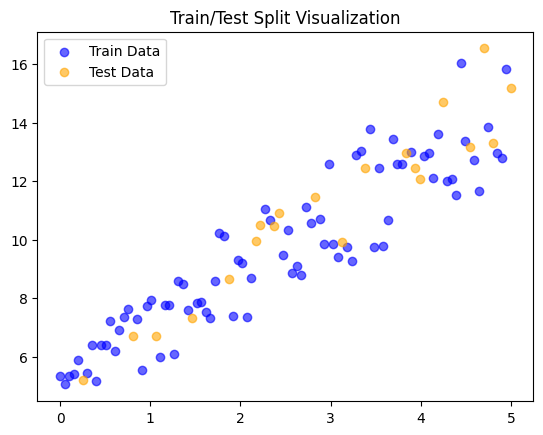

In [738]:
# Define split sizes
train_size = int(0.8 * len(X))
test_size = len(X) - train_size

# Generate random indices
indices = torch.randperm(len(X))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

# Split the data
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Visualize the split to ensure coverage
_ = plt.scatter(X_train, y_train, color='blue', label='Train Data', alpha=0.6)
_ = plt.scatter(X_test, y_test, color='orange', label='Test Data', alpha=0.6)
_ = plt.legend()
_ = plt.title("Train/Test Split Visualization")

### Data Loading Strategy

We wrap our tensors in a `Dataset` and `DataLoader` to automate the flow of data into the model.

* **TensorDataset**: Pairs features ($X$) and targets ($y$) into a single object.
* **DataLoader**: Handles the iteration logic.
* **Batch Size**: The number of samples used to calculate the gradient and update the weights in a single cycle. Smaller batches provide a "noisy" gradient that can help the model escape local minima.
* **`shuffle=True`**: Reorders the training data at the start of every epoch. This prevents the model from learning the sequence of the data and improves generalization.

### Mini-batch Execution Flow

When using a `DataLoader`, the optimization process changes from updating once per epoch to updating multiple times per epoch based on small subsets of data.

1. **The Epoch Starts**: The `DataLoader` shuffles the 80 samples. The data is split into 5 batches (16 samples each).
2. **Batch Processing**:
    * **Step 1**: Load the first **16 samples**.
    * **Step 2**: Calculate the gradient $\nabla J$ based **only** on those 16 samples.
    * **Step 3**: Update $\beta$ immediately using that gradient.
    * **Step 4**: Repeat for the next 4 batches.
3. **The Epoch Ends**: After 5 updates, the model has "seen" the entire dataset once.

For each batch ($B$), the parameters are updated using only the local gradient (derived from the **MSE** cost function):

$$\beta_{next} = \beta_{now} - \alpha \cdot \frac{2}{n_{batch}} X_B^T (X_B\beta - y_B)$$

* **$n_{batch}$**: The number of samples in the current batch (e.g., 16).
* **$X_B, y_B$**: The features and targets specific to that batch.

**Comparison**

| Feature | Batch GD | Mini-batch GD |
| :--- | :--- | :--- |
| **Data per Update** | Entire dataset | Small subset (Batch) |
| **Updates per Epoch** | 1 | Total samples / Batch size |
| **Convergence** | Stable and direct | Slightly "jumpy" but faster |
| **Memory Efficiency** | Low (needs all data) | High (only needs one batch) |

In [739]:
batch_size = 16

# Datasets
train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

# DataLoaders
# Shuffling the training data is crucial for Gradient Descent
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
# Shuffling test data isn't necessary, but we keep batching for consistency
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Quick check on a single batch
features, targets = next(iter(train_loader))
print(f"Batch features shape: {features.shape}")
print(f"Batch targets shape: {targets.shape}")

Batch features shape: torch.Size([16, 1])
Batch targets shape: torch.Size([16])


### Model Construction

In PyTorch, we build models by inheriting from `nn.Module`. This structure allows the framework to automatically track gradients and manage parameters.

* **`super().__init__()`**: This call is mandatory. It initializes the base `nn.Module` class, allowing PyTorch to register and track your model's parameters.
* **`nn.Parameter`**: A specialized tensor type. When assigned as a class attribute, PyTorch automatically includes it in the model's optimization list (accessible via `model.parameters()`).
* **`forward()`**: Defines the computation logic. This method is triggered when you call the model instance (e.g., `model(x)`), executing the $y = mx + b$ transformation.

In [740]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Initialize weights (ß1) and bias (ß0) with random values
    # We use nn.Parameter so PyTorch knows to track these for gradient descent
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True))
    self.bias = nn.Parameter(torch.randn(1, requires_grad=True))

  def forward(self, x):
    # The forward pass: y = mx + b
    return self.weights * x + self.bias

### What is a Layer?

A **layer** is a functional block containing a mathematical operation (like $y = mx + b$) and the learnable parameters (weights and biases) required for it. In this `LinearRegressionModel`, the entire operation acts as a single layer.

* **The `forward()` Method**: This defines the "Forward Pass" of the network. 
* **Why "Forward"?**: It describes the flow of data. Input $x$ is "forwarded" through the mathematical operations to produce the prediction $\hat{y}$.
* **Who receives it?**: The data is passed from the input, through each layer's transformation, until it reaches the final output used to calculate loss.

**Layers look like this, for example:**

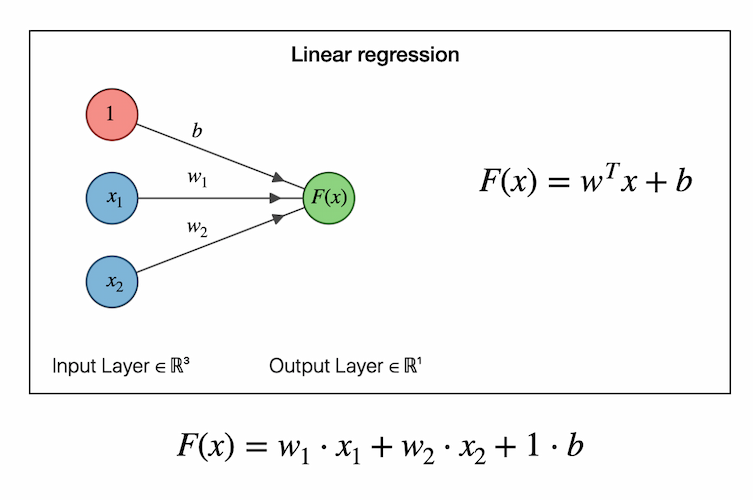

**Instantiate the Model**

In [741]:
# Set seed for reproducibility of parameter initialization
_ = torch.manual_seed(42)

# Instantiate the model
model = LinearRegressionModel()

print("Initial Parameters:")
print(f"Weights: {model.weights.item():.4f}")
print(f"Bias: {model.bias.item():.4f}")

# The state_dict maps the names we gave our parameters ('weights', 'bias') to their current values.
print("\nModel State Dict:")
print(model.state_dict())

# model.parameters() returns a generator (iterator) of all tensors tracked by the model. The optimizer doesn't
# care about the names 'weights' or 'bias'; it just needs this generator
# to loop through the tensors and subtract the gradient.
print("\nModel Parameters (Generator):")
print(next(model.parameters()))  # Accessing the first parameter (weights)
print(next(model.parameters()))  # Accessing the second parameter (bias)

Initial Parameters:
Weights: 0.3367
Bias: 0.1288

Model State Dict:
OrderedDict({'weights': tensor([0.3367]), 'bias': tensor([0.1288])})

Model Parameters (Generator):
Parameter containing:
tensor([0.3367], requires_grad=True)
Parameter containing:
tensor([0.3367], requires_grad=True)


### Custom Loss Construction

* **Why a Class?**: Inheriting from `nn.Module` integrates the loss into the computational graph. It ensures the operation is tracked by the autograd engine for backpropagation.
* **The `forward()` Method**: It calculates the "Forward Pass" of the error. It transforms predictions and targets into a single scalar loss value, which serves as the starting point for gradient calculations.

In [742]:
class MeanSquaredError(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)  # MSE

**Instantiate the custom loss**

In [743]:
mse_loss = MeanSquaredError()

# Create dummy tensors to test
y_true = torch.tensor([1.0, 2.0, 3.0])
y_pred = torch.tensor([1.5, 2.5, 3.5])

# Calculate loss
loss = mse_loss(y_pred, y_true)
print(f"Calculated Loss: {loss.item():.4f}")

Calculated Loss: 0.2500


**Evaluation Mode**

* **`torch.inference_mode()`**: A context manager that disables gradient tracking. It makes the code faster and more memory-efficient when you only need predictions (inference) without updates.
* **Initial Loss**: Since the model weights are currently random, this loss value represents the "baseline" error we aim to minimize through training.


**Visualizing**

* **Red Dots**: The ground truth ($y_{test}$) values the model is trying to learn.
* **Blue Line**: The model’s current hypothesis ($y = mx + b$). Since weights are random, it likely won't fit yet.
* **Vertical Dashed Lines**: Represent the **residuals** ($y - \hat{y}$). The MSE loss is essentially the average of these squared distances.

Initial Test Loss: 107.1064


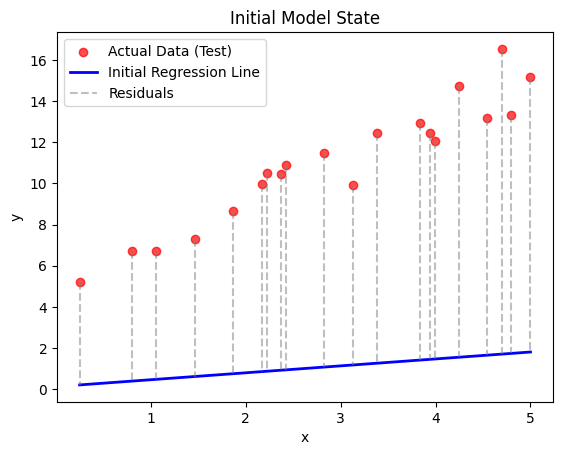

In [744]:
with torch.inference_mode():
  y_test_pred = model(X_test)
  initial_loss = mse_loss(y_test_pred, y_test)

print(f"Initial Test Loss: {initial_loss.item():.4f}")

# Actual Test Data
_ = plt.scatter(X_test, y_test, color='red', label='Actual Data (Test)', alpha=0.7)

# Model Prediction Line
# We sort X_test to ensure the line plots correctly from left to right
X_range = torch.linspace(X_test.min(), X_test.max(), 100).unsqueeze(1)
with torch.inference_mode():
  y_range_pred = model(X_range)
_ = plt.plot(X_range, y_range_pred, color='blue', label='Initial Regression Line', linewidth=2)

# Residuals
_ = plt.vlines(X_test, y_test, y_test_pred, color='gray',
               linestyle='--', alpha=0.5, label='Residuals')
_ = plt.title(f"Initial Model State")
_ = plt.xlabel("x")
_ = plt.ylabel("y")
_ = plt.legend()

### Model Training and Optimization

We use built-in PyTorch utilities to handle the mathematical heavy lifting of the update cycle.

* **`nn.MSELoss()`**: The standard implementation of the L2 loss. It handles the squaring and averaging of residuals efficiently.
* **`torch.optim.SGD`**: Implements the Stochastic Gradient Descent algorithm.
* **`model.parameters()`**: Informs the optimizer which specific tensors (weights and bias) it has permission to modify.
* **`lr` (Learning Rate)**: A hyperparameter that scales the gradient, determining the size of the step taken toward the minimum.

In [745]:
# Step size for gradient descent
learning_rate = 0.01

# Use the built-in Mean Squared Error loss (L2)
loss_fn = nn.MSELoss()

# Initialize the 'Stochastic Gradient Descent' optimizer
# We pass model.parameters() so it knows which tensors to update
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(f"Loss Function: {loss_fn}\n")
print(f"Optimizer: {optimizer}")

Loss Function: MSELoss()

Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


### The Training Loop

* **Initial Loss**: Calculated before training to establish a baseline for the model's performance with random parameters.
* **`model.train()`**: Sets the model to training mode, enabling gradient tracking and layer-specific training behaviors.
* **Forward Pass**: Passes input $X$ through the model to generate predictions $\hat{y}$.
* **Loss Calculation**: Quantifies the distance between $\hat{y}$ and true $y$ using `loss_fn`.
* **`optimizer.zero_grad()`**: Resets gradient buffers. Since PyTorch accumulates gradients by default, this ensures updates are based only on the current batch.
* **`loss.backward()`**: Triggers backpropagation, calculating the gradient of the loss with respect to each parameter.
* **`optimizer.step()`**: Updates parameters ($w$ and $b$) by moving them in the opposite direction of the gradient.

In [746]:
epochs = 200

# Calculate and print initial loss for comparison
_ = model.eval()
with torch.inference_mode():
  initial_y_pred = model(X_train).squeeze()
  initial_loss = loss_fn(initial_y_pred, y_train)
  print(f"Initial Training Loss: {initial_loss.item():.4f}")
  print("-" * 30)

# Training Loop
for epoch in range(epochs):
  _ = model.train()

  for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
    # 1. Forward pass
    y_pred = model(X_batch).squeeze()

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_batch)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backward pass
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Print progress every 10 epochs
  if epoch % 10 == 0:
    print(f"Epoch: {epoch:3d} | Loss: {loss.item():.4f}")

Initial Training Loss: 80.0766
------------------------------
Epoch:   0 | Loss: 24.3842
Epoch:  10 | Loss: 4.5822
Epoch:  20 | Loss: 2.6128
Epoch:  30 | Loss: 1.8084
Epoch:  40 | Loss: 2.2859
Epoch:  50 | Loss: 1.5392
Epoch:  60 | Loss: 1.2955
Epoch:  70 | Loss: 1.5716
Epoch:  80 | Loss: 1.1150
Epoch:  90 | Loss: 1.7202
Epoch: 100 | Loss: 1.7311
Epoch: 110 | Loss: 1.9564
Epoch: 120 | Loss: 1.1323
Epoch: 130 | Loss: 0.8906
Epoch: 140 | Loss: 0.8158
Epoch: 150 | Loss: 0.8460
Epoch: 160 | Loss: 0.8285
Epoch: 170 | Loss: 0.6761
Epoch: 180 | Loss: 2.1914
Epoch: 190 | Loss: 0.5953


**Post-Training Visualization**

Learned Equation: y = 1.76x + 5.40
Final Test Loss: 1.1442


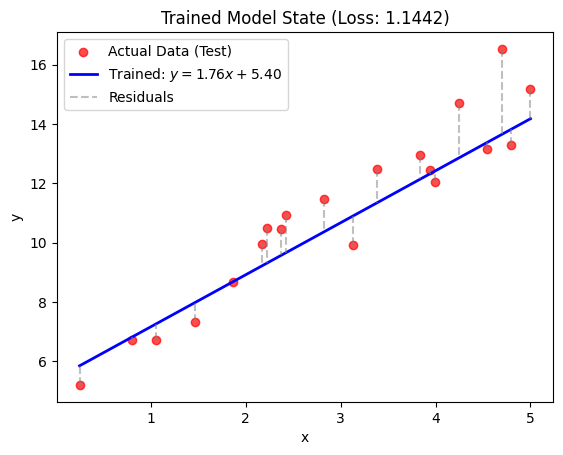

In [747]:
# Extract the learned parameters
m_learned = model.weights.item()
b_learned = model.bias.item()

print(f"Learned Equation: y = {m_learned:.2f}x + {b_learned:.2f}")

with torch.inference_mode():
  y_test_pred = model(X_test).squeeze()
  final_loss = loss_fn(y_test_pred, y_test)

print(f"Final Test Loss: {final_loss.item():.4f}")

# Actual Test Data
_ = plt.scatter(X_test, y_test, color='red', label='Actual Data (Test)', alpha=0.7)

# Model Prediction Line
X_range = torch.linspace(X_test.min(), X_test.max(), 100).unsqueeze(1)
with torch.inference_mode():
  y_range_pred = model(X_range)
_ = plt.plot(X_range, y_range_pred, color='blue',
             label=f'Trained: $y = {m_learned:.2f}x + {b_learned:.2f}$', linewidth=2)

# Residuals
_ = plt.vlines(X_test, y_test, y_test_pred, color='gray',
               linestyle='--', alpha=0.5, label='Residuals')

_ = plt.title(f"Trained Model State (Loss: {final_loss.item():.4f})")
_ = plt.xlabel("x")
_ = plt.ylabel("y")
_ = plt.legend()

**Analytical Best Fit (Numpy Polyfit)**

In [748]:
# Convert tensors back to numpy for polyfit
x_np = x.numpy()
y_np = y.numpy()

m_poly, b_poly = np.polyfit(x_np, y_np, deg=1)

# Calculate Analytical Prediction & MSE
y_pred_poly = m_poly * x_np + b_poly
mse_poly = np.mean((y_np - y_pred_poly)**2)

print(f"--- Analytical (Polyfit) Results ---")
print(f"Equation: y = {m_poly:.2f}x + {b_poly:.2f}")
print(f"MSE: {mse_poly:.4f}")

print(f"\n--- Gradient Descent Results ---")
print(f"Equation: y = {m_learned:.2f}x + {b_learned:.2f}")
print(f"MSE: {final_loss.item():.4f}")

--- Analytical (Polyfit) Results ---
Equation: y = 1.81x + 5.35
MSE: 1.1456

--- Gradient Descent Results ---
Equation: y = 1.76x + 5.40
MSE: 1.1442
